### Car Brand Classification

##### Import

In [1]:
all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

##### Data load

In [3]:
PATH = 'd:/CarsDataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
# batchsize, image size 지정
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3352 files belonging to 7 classes.
Found 813 files belonging to 7 classes.


In [5]:
class_names = train_dataset.class_names
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

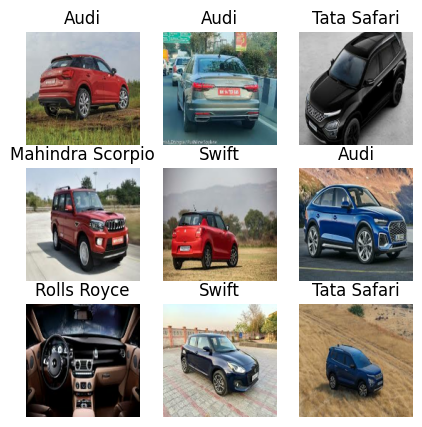

In [6]:
plt.figure(figsize=(5, 5))

for images, labels in train_dataset.take(1):
  for i in range(9):  # 9개의 이미지 출력
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 이미지 표현을 위해 numpy 배열 dtype을 uint8로 지정
    plt.title(class_names[labels[i]])  # images에 해당하는 레이블 출력
    plt.axis("off") 

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

##### Data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.3)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


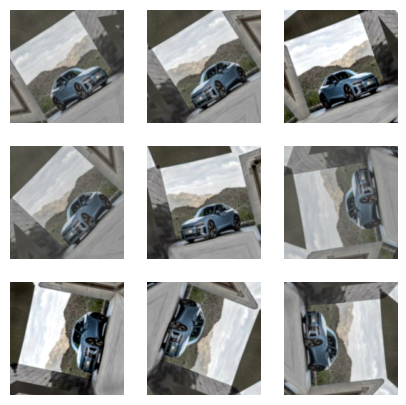

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(5,5))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # tf.expand_dims를 통해 기존 이미지의 차원을 확장함 (first_image : 차원이 늘려질 배열, 0(axis) : 몇 번째 차원의 크기를 늘릴 것인지)
    # 차원 확장 후 이미지 증강 기법 적용
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Transfer learning - MobileNetV2

##### Feature Extraction

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescaling과 같은 기능

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [13]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # 데이터 증강
x = preprocess_input(x) # 전처리
x = base_model(x, training=False) # MobileNet V2d의 basemodel
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  # output layer
model = tf.keras.Model(inputs, outputs)

##### Compile Model

In [15]:
base_learning_rate = 0.0001  # 학습률 지정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
105/105 [==============================] - 8s 41ms/step - loss: 2.1696 - accuracy: 0.2053 - val_loss: 1.8468 - val_accuracy: 0.2534
Epoch 2/10
105/105 [==============================] - 3s 31ms/step - loss: 1.9234 - accuracy: 0.2870 - val_loss: 1.6760 - val_accuracy: 0.3764
Epoch 3/10
105/105 [==============================] - 3s 31ms/step - loss: 1.7851 - accuracy: 0.3422 - val_loss: 1.5371 - val_accuracy: 0.4453
Epoch 4/10
105/105 [==============================] - 3s 31ms/step - loss: 1.6682 - accuracy: 0.3917 - val_loss: 1.4360 - val_accuracy: 0.5031
Epoch 5/10
105/105 [==============================] - 3s 30ms/step - loss: 1.5695 - accuracy: 0.4323 - val_loss: 1.3606 - val_accuracy: 0.5449
Epoch 6/10
105/105 [==============================] - 3s 30ms/step - loss: 1.4875 - accuracy: 0.4535 - val_loss: 1.2897 - val_accuracy: 0.5633
Epoch 7/10
105/105 [==============================] - 3s 29ms/step - loss: 1.4264 - accuracy: 0.4911 - val_loss: 1.2275 - val_accuracy: 0.5966

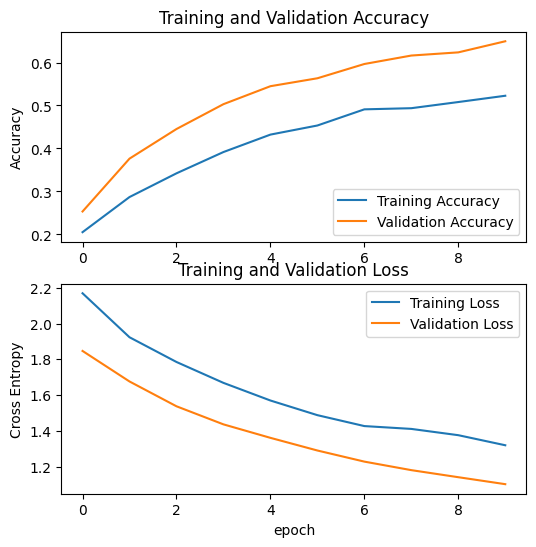

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Fine tuning

In [19]:
base_model.trainable = True

In [51]:
print(len(base_model.layers))

for i, j in enumerate(base_model.layers):
    print(i, j.name)

154
0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu


In [20]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
# block_11_expand_BN까지 학습을 동결함
# 블록 11의 맨 처음 Conv layer와 Batch Normal layer를 닫은 이후의 레이어들의 파라미터만 학습함

In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
105/105 [==============================] - 8s 47ms/step - loss: 1.2560 - accuracy: 0.5501 - val_loss: 0.9490 - val_accuracy: 0.7023
Epoch 11/20
105/105 [==============================] - 4s 40ms/step - loss: 1.0985 - accuracy: 0.6053 - val_loss: 0.8102 - val_accuracy: 0.7454
Epoch 12/20
105/105 [==============================] - 4s 40ms/step - loss: 1.0338 - accuracy: 0.6342 - val_loss: 0.7815 - val_accuracy: 0.7319
Epoch 13/20
105/105 [==============================] - 4s 40ms/step - loss: 0.9329 - accuracy: 0.6715 - val_loss: 0.6578 - val_accuracy: 0.7884
Epoch 14/20
105/105 [==============================] - 4s 40ms/step - loss: 0.8831 - accuracy: 0.6957 - val_loss: 0.6570 - val_accuracy: 0.7749
Epoch 15/20
105/105 [==============================] - 4s 40ms/step - loss: 0.8095 - accuracy: 0.7115 - val_loss: 0.5713 - val_accuracy: 0.8118
Epoch 16/20
105/105 [==============================] - 4s 40ms/step - loss: 0.7655 - accuracy: 0.7461 - val_loss: 0.5275 - val_accuracy:

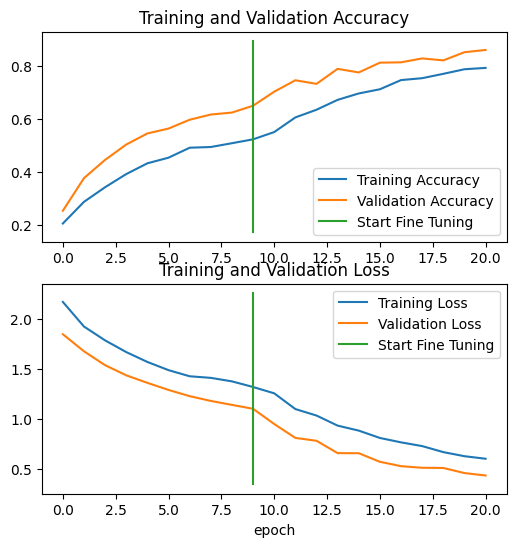

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Predict & Evaluation

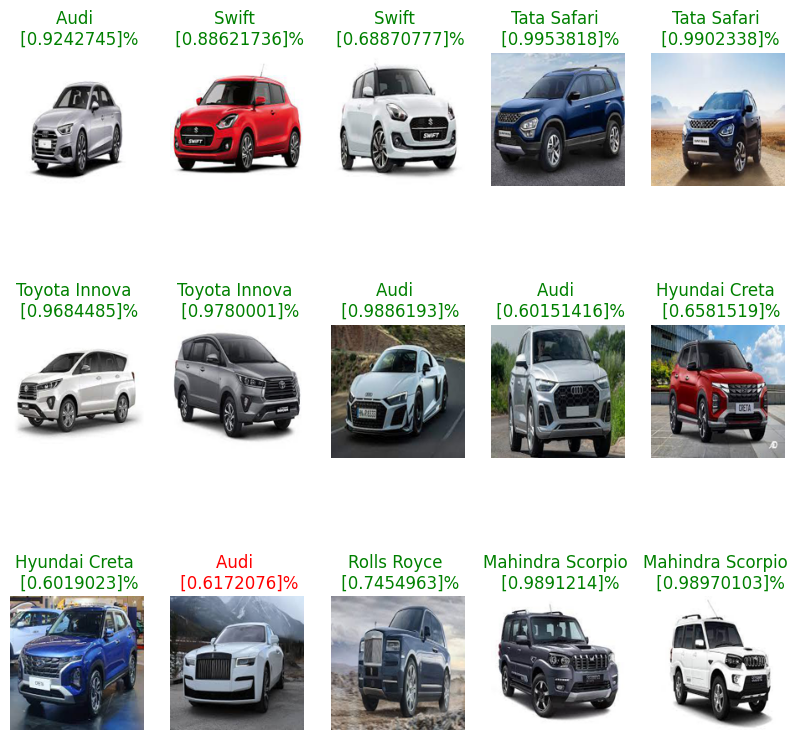

In [25]:
from PIL import Image
from glob import glob

test_dir = 'd:/CarsDataset/test_img/*'
test_files=glob(test_dir)

real_test_labes = [0,4,4,5,5,6,6,0,0,1,1,3,3,2,2]   # 실제 testset 라벨 값

plt.figure(figsize=(10,10))

for n, file in enumerate(test_files):
    ax=plt.subplot(3,5,n+1)
    img=Image.open(file).resize((160,160)).convert('RGB')
    img=np.array(img)
    newimg=np.reshape(img, (1,160,160,3))
    pred=model.predict(newimg)
    predBun=np.argmax(pred)
    # print(class_names[predBun], pred[:,predBun])
    plt.title(f'{class_names[predBun]}: {pred[:,predBun]}%')
    # plt.figure(figsize=(3,3))
    plt.imshow(img)
    color = "green" if predBun == real_test_labes[n] else "red"
    plt.title(f'{class_names[predBun]} \n {pred[:,predBun]}%', color=color)
    # plt.show()
    plt.axis("off")


In [26]:
import time
t = time.time()

export_path = "saved_models_MobileNetV2/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: saved_models_MobileNetV2/1688605713\assets


'saved_models_MobileNetV2/1688605713'

In [27]:
# test_directory = 'd:/CarsDataset/test_img/*'

# test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
#                                                             shuffle=True,
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=IMG_SIZE)

# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [28]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [29]:
# preds=model.predict(test_dataset)
# preds

### Transfer learning - ResNet50

##### Feature Extraction

In [41]:
base_model_2 = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

In [42]:
base_model_2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [43]:
preprocess_input_2 = tf.keras.applications.resnet50.preprocess_input

In [44]:
base_model_2.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [45]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # 데이터 증강
x = preprocess_input_2(x) # 전처리
x = base_model_2(x, training=False) # MobileNet V2d의 basemodel
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  # output layer
model_2 = tf.keras.Model(inputs, outputs)

In [46]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

##### Compile Model

In [47]:
base_learning_rate = 0.0001  # 학습률 지정
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
initial_epochs = 10

#러닝레이트의 비율을 유동적으로 변화할 수 있도록 설정함
def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

history_2 = model_2.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[lr_scheduler_cb])

Epoch 1/10


105/105 [==============================] - 10s 69ms/step - loss: 2.3508 - accuracy: 0.2258 - val_loss: 1.8378 - val_accuracy: 0.3272 - lr: 1.0000e-04
Epoch 2/10
105/105 [==============================] - 6s 61ms/step - loss: 2.0275 - accuracy: 0.2813 - val_loss: 1.6133 - val_accuracy: 0.4170 - lr: 1.0000e-04
Epoch 3/10
105/105 [==============================] - 6s 59ms/step - loss: 1.8276 - accuracy: 0.3470 - val_loss: 1.4482 - val_accuracy: 0.4674 - lr: 1.0000e-04
Epoch 4/10
105/105 [==============================] - 6s 60ms/step - loss: 1.6620 - accuracy: 0.3977 - val_loss: 1.3396 - val_accuracy: 0.5264 - lr: 1.0000e-04
Epoch 5/10
105/105 [==============================] - 6s 60ms/step - loss: 1.5652 - accuracy: 0.4275 - val_loss: 1.2413 - val_accuracy: 0.5609 - lr: 1.0000e-04
Epoch 6/10
105/105 [==============================] - 6s 61ms/step - loss: 1.5133 - accuracy: 0.4561 - val_loss: 1.1694 - val_accuracy: 0.5732 - lr: 9.0484e-05
Epoch 7/10
105/105 [==============================

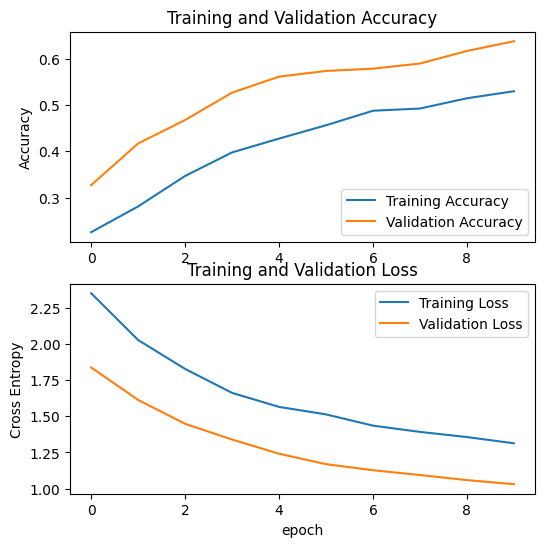

In [49]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Fine Tuning

In [50]:
base_model_2.trainable = True
len(base_model_2.layers)

175

In [ ]:
fine_tune_at = 100

for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable = False